# TME 3 - Régularisation L1


In [35]:
import numpy as np
from sklearn import datasets
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import functools
import operator
import itertools

%matplotlib inline

# Loading 'breast cancer' dataset, a simple dataset
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target

X, y = shuffle(X, y)

# Decrease data to speed up computation
# X = X[:50,:5]
# y = y[:50]

print("shape of X:", X.shape)
print("shape of Y:", y.shape)
print("classes in Y: ", np.unique(y, return_counts=True))

shape of X: (569, 30)
shape of Y: (569,)
classes in Y:  (array([0, 1]), array([212, 357]))


In [5]:
from scipy.optimize import approx_fprime, check_grad, minimize


def decision(theta, X):
    """ The decision function that predicts a target
    :param theta: The parameter for the decision
    :param X: The data.
    
    theta.shape = (n,) and X.shape = (l, n)
    :return: a vector of predictions of shape (l,)"""
    return np.sign(X.dot(theta)) / 2 + 0.5

def loss(theta, X, y, pen):
    """ The loss function
    :param theta: The vector doing the decision
    :param X: The data
    :param y: The target values
    :param pen: The penalization parameter (The higher 'pen', the lower |theta|)
    :return: The loss for the given parameters.
    """
    mse = ((y - X.dot(theta))**2).mean()
    return mse + pen * sum([np.abs(t) for t in theta])

def gradient_loss(theta, X, y, pen):
    """ The gradient of the loss function
    :param theta: The vector doing the decision
    :param X: The data
    :param y: The target values
    :param pen: The penalization parameter
    :return: The gradient of the for the given parameters.
    """
    gradient = 2 * X.T.dot(X.dot(theta) - y) / X.shape[0] + pen * np.sign(theta)
    return gradient

### Testing if the gradient is correct ### 
print("Checking gradient_loss with random theta:")
np.set_printoptions(precision=1, threshold=5)
for i in range(10):
    print("\n### Iteration %d ###" % i)
    theta = np.random.random(X[0].shape) - 0.5
    theta *= 10**np.random.randint(1, 8)
    pen = np.random.random() / 10
    func = lambda t:loss(t, X, y, pen)
    grad = lambda t:gradient_loss(t, X, y, pen)
    print("Theta :                               ", theta)
    print("Gradient according to approx_fprime():", approx_fprime(theta, func, epsilon=1))
    print("Gradient according to gradient_loss():", grad(theta))
    err = check_grad(func, grad, theta)
    print("Error according to check_grad(): %f (%f%%)" % (err, err / np.linalg.norm(grad(theta)) * 100))

Checking gradient_loss with random theta:

### Iteration 0 ###
Theta :                                [ 4262.5  2658.5 -3385.7   850.3  2703.2]
Gradient according to approx_fprime(): [  1.5e+07   1.8e+07   9.6e+07   8.2e+08   8.3e+04]
Gradient according to gradient_loss(): [  1.5e+07   1.8e+07   9.6e+07   8.2e+08   8.3e+04]
Error according to check_grad(): 3845.560374 (0.000467%)

### Iteration 1 ###
Theta :                                [ 21457.4 -23410.2  25486.9  12351.4 -44250.4]
Gradient according to approx_fprime(): [  3.9e+08   4.9e+08   2.6e+09   2.1e+10   2.3e+06]
Gradient according to gradient_loss(): [  3.9e+08   4.9e+08   2.6e+09   2.1e+10   2.3e+06]
Error according to check_grad(): 4633054.184045 (0.021467%)

### Iteration 2 ###
Theta :                                [ 13.7  18.1  43.   37.8  18.5]
Gradient according to approx_fprime(): [  1.1e+06   1.4e+06   7.4e+06   6.2e+07   6.6e+03]
Gradient according to gradient_loss(): [  1.1e+06   1.4e+06   7.4e+06   6.1e+07   6.6

theta with gradient_l1(): [-0.08 -0.05 -0.04 ..., -0.06 -0.45 -0.12]
theta with minimize()   : [  4.32e-01  -2.04e-03  -2.50e-02 ...,  -5.31e-01  -6.61e-01  -6.48e+00]
Errors: 210/569


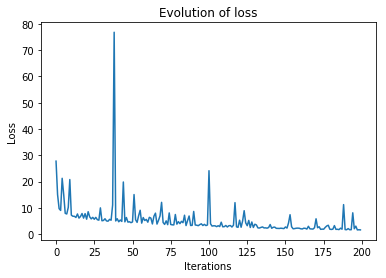

In [54]:
def gradient_l1(theta, X, y, max_iter=100, step=1e-1, pen=0.1, verbose=0, plot=False, force=False):
    """ Performs gradient clipping to find the best theta
    :param theta: The initial scalar for the search
    :param X: The data
    :param y: The target values
    :param max_iter: The number of iterations
    :param step: The scalar the will be multiplied to the gradient vector to increment theta
    :param pen: The regularization parameter
    :param verbose: The level of displayed information
    :param plot: Whether to plot the evolution of the loss
    :param force: Whether to deactivate the warning if too much output
    
    :return: The theta at the end of the gradient descent"""
    
    (l, n) = X.shape
    losses = []
    
    if not force and verbose > 1 and max_iter > 50:
        print("Warning, there will be a lot of output, it can freeze the kernel.")
        print("If you really want to proceed, relaunch with 'force=True'")
        return 
    
    for it in range(max_iter):
        if verbose >= 1:
            print("###########  Step", it, ": #################")
        for i in range(l):
            # Sample a random point 
            idx = np.random.randint(0, l)
            if verbose >= 2:
                print("========= i = %d, random idx = %d ===========" % (i, idx))
            # Compute the gradient on this single random point:
            local_loss = lambda t: loss(t, np.array([X[idx]]), np.array([y[idx]]), pen)
#             grad = approx_fprime(theta, local_loss, epsilon=step)
            
            grad = gradient_loss(theta, np.array([X[idx]]), np.array([y[idx]]), pen)
            
            #debug
            if verbose >=2:
                local_grad = lambda t: gradient_loss(theta, np.array([X[idx]]), np.array([y[idx]]), pen)
                print("debug: check_grad:", check_grad(local_loss, local_grad, theta))
                
            if verbose >= 2:
                print("Gradient:     ",grad)
                print("Theta before: ", theta)
                
#             step = minimize(lambda s: local_loss(theta - s*grad), step).x

            theta_prime = theta - step * grad
            theta_prime[theta * theta_prime < 0] = 0
            theta = theta_prime
            
            if verbose >= 2:
                print("Step: ", step)
                print("Theta after:  ", theta)
                
        general_loss = loss(theta, X, y, pen)
        losses.append(general_loss)
        if verbose >= 1:
            print("Loss :     %f" % (general_loss))
            errors = np.count_nonzero(decision(theta, X) - y)
            print("Accuracy : %d/%d right guesses" % (l - errors, l))
    
    if plot:
        plt.plot(losses)
        plt.title("Evolution of loss")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        
    return theta

# Optimization parameters
theta_init = np.random.random(X[0].shape) - 0.5
max_iter = 200
step     = 1e-7
pen      = 0

# Find theta 
np.set_printoptions(precision=2, threshold=5)
theta = gradient_l1(theta_init, X, y, max_iter=max_iter, pen=pen, step=step, verbose=0, plot=True)
theta_minimize = minimize(lambda t:loss(t, X, y, pen), theta_init).x
print("theta with gradient_l1():", theta)
print("theta with minimize()   :", theta_minimize)

errs = np.count_nonzero(decision(theta, X) - y)
print("Errors: %d/%d" % (errs, len(X)))


In [55]:
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """ Custom linear classifier """
    
    def __init__(self, max_iter=1000, step=1e-2, pen=1e-2, verbose=0):
        self.theta= 0
        self.max_iter = max_iter
        self.step = step
        self.pen = pen
        self.verbose = verbose
    
    def fit(self, X, y):        
        self.theta = gradient_l1(np.ones_like(X[0]), X, y, 
                                 max_iter=self.max_iter, 
                                 step=self.step, 
                                 pen=self.pen,
                                 verbose=self.verbose)
        
    def predict(self, X):
        return decision(self.theta, X)

    def get_theta(self):
        return self.theta

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score



print("Evaluating the classifier:")
for it in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    clf = LinearClassifier(max_iter=max_iter, step=step, pen=pen, verbose=0)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(20 * '-')
    print("y_pred: ", pred)
    print("y_reel: ", y_test)
    print("Score: ", accuracy_score(pred, y_test))
    print("Errors on following labels: ", np.unique(y_test[pred != y_test], return_counts=True))
    errs = np.count_nonzero(decision(clf.get_theta(), X_train) - y_train)
    print("Errors on the training set: %d/%d" % (errs, len(X_train)))


print(20*'#' + '\n')
print("Evaluating with cross validation")
kf = KFold(n_splits=10)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LinearClassifier(max_iter=max_iter, step=step, pen=pen, verbose=0)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(20 * '-')
    print("y_pred: ", pred)
    print("y_reel: ", y_test)
    print("Score: ", accuracy_score(pred, y_test))
    print("Errors on following labels: ", np.unique(y_test[pred != y_test], return_counts=True))
    errs = np.count_nonzero(decision(clf.get_theta(), X_train) - y_train)
    print("Errors on the training set: %d/%d" % (errs, len(X_train)))


    


Evaluating the classifier:
--------------------
y_pred:  [ 0.  1.  1. ...,  0.  1.  1.]
y_reel:  [1 1 1 ..., 1 0 1]
Score:  0.587719298246
Errors on following labels:  (array([0, 1]), array([22, 25]))
Errors on the training set: 237/455
--------------------
y_pred:  [ 1.  1.  0. ...,  0.  0.  1.]
y_reel:  [1 1 1 ..., 1 1 1]
Score:  0.517543859649
Errors on following labels:  (array([0, 1]), array([21, 34]))
Errors on the training set: 219/455
--------------------
y_pred:  [ 0.  1.  1. ...,  0.  1.  1.]
y_reel:  [1 0 1 ..., 1 1 1]
Score:  0.482456140351
Errors on following labels:  (array([0, 1]), array([44, 15]))
Errors on the training set: 219/455
--------------------
y_pred:  [ 1.  0.  0. ...,  1.  1.  1.]
y_reel:  [0 1 1 ..., 0 0 0]
Score:  0.447368421053
Errors on following labels:  (array([0, 1]), array([36, 27]))
Errors on the training set: 242/455
--------------------
y_pred:  [ 1.  1.  1. ...,  1.  1.  1.]
y_reel:  [0 0 1 ..., 1 0 1]
Score:  0.587719298246
Errors on following l

# Q4) Performance en fonction de la parcimonie du modèle

**Performance** : pourcentage de bonne classification sur un ensemble de test

**Parcimonie** : Le nombre d'éléments différents de 0, divisé par le nombre total d'éléments.

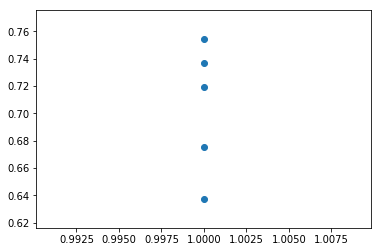

In [70]:
def sparsity(vect):
    return np.count_nonzero(vect)/len(vect)

scores = []
spars = []
kf = KFold(n_splits=5)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = LinearClassifier(max_iter=20, step=step, pen=1e-1, verbose=2)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    scores.append(accuracy_score(pred, y_test))
    spars.append(sparsity(clf.get_theta()))
    
plt.scatter(spars, scores);


Apparemment, aucun des vecteurs n'a de composante nulle...